In [1]:
import pandas as pd
import numpy as np
import re
import operator
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/home/wooj/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


From our initial exploration, we found that the data was organized in a binary-tree structure - each phrase breaks off into two smaller phrases.

In [2]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


We plotted the counts for each of the sentiment classes to roughly observe the distribution of the data.

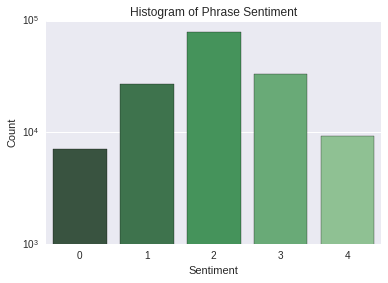

In [3]:
# Plots the sentiment histogram on a semilog-y plot
sns.countplot(x="Sentiment", data=train, palette="Greens_d")
plt.title("Histogram of Phrase Sentiment")
plt.ylabel("Count")
plt.yscale('log')

We then looked at all of the one-word phrases to see if we can find any noticeable patterns. We printed a few of the words in each class to see if our script worked.

In [4]:
# Extracts one-word phrases using a regular expression
regexp = re.compile(' ')
words = train[~train.Phrase.str.contains(' ')]
words = words[words.Phrase.str.contains('^[a-zA-Z]+$')]
words.Phrase = words.Phrase.str.lower()

# Organizes words by sentiment
classes = [words[words.Sentiment == 0],
           words[words.Sentiment == 1],
           words[words.Sentiment == 2],
           words[words.Sentiment == 3],
           words[words.Sentiment == 4]]

# Prints a few words from each sentiment class
print "0:"
print classes[0].Phrase.unique()[0:5]
print ""
print "1:"
print classes[1].Phrase.unique()[0:5]
print ""
print "2:"
print classes[2].Phrase.unique()[0:5]
print ""
print "3:"
print classes[3].Phrase.unique()[0:5]
print ""
print "4:"
print classes[4].Phrase.unique()[0:5]

0:
['hate' 'avoid' 'bad' 'impossible' 'fails']

1:
['deceit' 'murder' 'tragedy' 'trouble' 'plodding']

2:
['a' 'series' 'of' 'escapades' 'demonstrating']

3:
['good' 'amuses' 'fans' 'positively' 'intrigue']

4:
['entertaining' 'thrilling' 'joy' 'extravagant' 'better']


We noticed that a lot of the data in the neutral class consisted of articles, conjunctions, and other short, miscellaneous words. So, we plotted a histogram of word sentiment using hue to represent the length of each word. We noticed that there are very few non-neutral words in the data, and the proportion of the neutral words drops off significantly as the length of the word increases. 

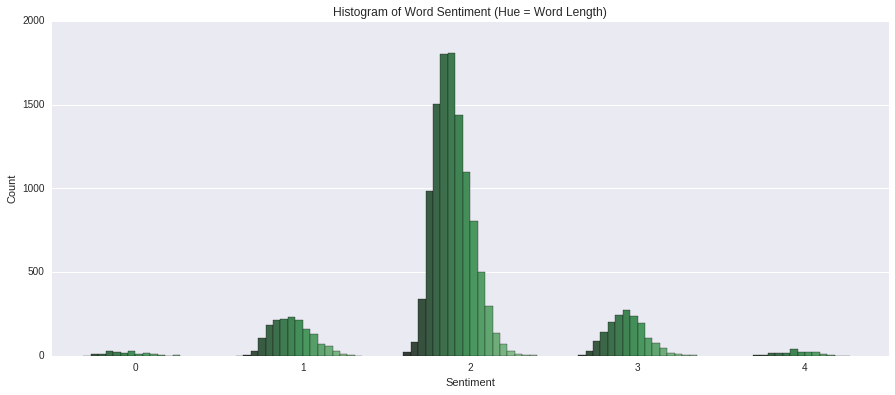

In [5]:
# Plots a histogram of the word sentiment, by word length
plt.figure(figsize=(15, 6))
ax = sns.countplot(x="Sentiment", data=words, hue=words.Phrase.str.len(), palette="Greens_d")
ax.legend().set_visible(False)
plt.title("Histogram of Word Sentiment (Hue = Word Length)")
plt.ylabel("Count")

In addition to single-word phrases, we also looked into phrases that consist of two or more words. As the number of words starts to increase, we noticed that the relative amount of neutral phrases decreases.

/home/wooj/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


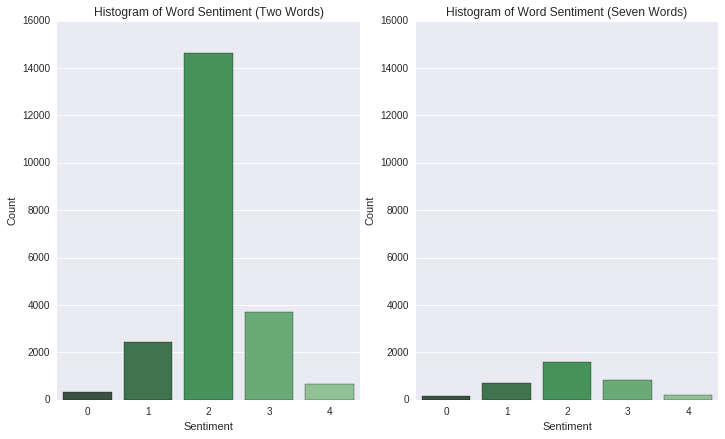

In [6]:
two_words = train[train.Phrase.str.contains('^[A-Za-z]* [A-Za-z]*$')]
two_words.Phrase = train.Phrase.str.lower()

seven_words = train[train.Phrase.str.contains('^[A-Za-z]* [A-Za-z]* [A-Za-z]* [A-Za-z]* [A-Za-z]* [A-Za-z]* [A-Za-z]*$')]
seven_words.Phrase = train.Phrase.str.lower()

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
sns.countplot(x="Sentiment", data=two_words, palette="Greens_d")
plt.title("Histogram of Word Sentiment (Two Words)")
plt.ylabel("Count")
# plt.yscale('log')
plt.ylim([0, 1.6e4])

plt.subplot(1,2,2)
sns.countplot(x="Sentiment", data=seven_words, palette="Greens_d")
plt.title("Histogram of Word Sentiment (Seven Words)")
plt.ylabel("Count")
# plt.yscale('log')
plt.ylim([0, 1.6e4])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

We also looked at full sentences to observe their sentiment distribution. The number of items in the neutral class significantly decreased, while the number of somewhat negative (1) and somewhat positive (3) items increased.

In [7]:
# Only extracts the sentences from the dataset
sentences_dict = train['SentenceId'].drop_duplicates()
sentences = train.iloc[sentences_dict.keys()]
sentences.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


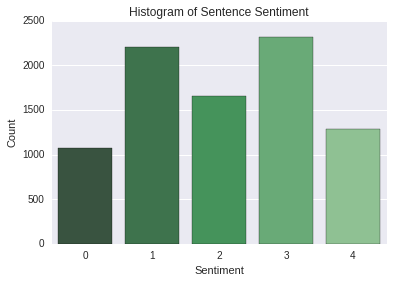

In [8]:
sns.countplot(x="Sentiment", data=sentences, palette="Greens_d")
plt.title("Histogram of Sentence Sentiment")
plt.ylabel("Count")

Since we are thinking of using a Naive Bayes approach to the model, we tried calculating the average sentiment of all the phrases that branch off of each sentence. We then compared this to the actual sentiment of the sentence to see if they matched up. Our basic model, however, does not seem to match up well to the actual sentiment of each sentence.

In [9]:
non_sentences_idx = [x for x in range(len(train)) if x not in sentences_dict]
non_sentences = train.iloc[non_sentences_idx]
non_sentences[0:10]

,PhraseId,SentenceId,Phrase,Sentiment
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2
10,11,1,demonstrating the adage,2


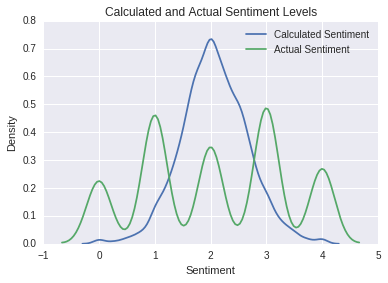

In [10]:
avg_sentiment = non_sentences.groupby(['SentenceId']).mean().Sentiment
sns.kdeplot(avg_sentiment, label="Calculated Sentiment")
sns.kdeplot(sentences.Sentiment, label="Actual Sentiment")
plt.xlabel('Sentiment')
plt.ylabel('Density')
plt.title('Calculated and Actual Sentiment Levels')

# len(sentences.Sentiment) - len(avg_sentiment)

We also looked at negations and how they might affect the model that we will implement later. We looked at one phrase in particular: "It's not a particularly good film." Although "a particularly good film" has a very positive sentiment (4), "It's not a particularly good film" causes the sentiment to drop to being negative (1). When we are designing our model, this is definitely something we should look out for.

In [11]:
sentences[sentences.Phrase.str.contains('no |not ')][0:10]

,PhraseId,SentenceId,Phrase,Sentiment
848,849,32,"Hampered -- no , paralyzed -- by a self-indulg...",0
1224,1225,46,Less the sensational true-crime hell-jaunt pur...,3
1400,1401,52,Finally coming down off of Miramax 's deep she...,2
1917,1918,71,But it has an ambition to say something about ...,1
2413,2414,93,Entertains not so much because of its music or...,1
2519,2520,97,"`` Analyze That '' is one of those crass , con...",0
2580,2581,99,"It 's not a particularly good film , but neith...",2
2971,2972,113,The whole film has this sneaky feel to it -- a...,0
3064,3065,115,"Swinging , the film makes it seem , is not a h...",1
3904,3905,149,Because Eight Legged Freaks is partly an homag...,2


In [12]:
print train[train.Phrase == "a particularly good film"].Sentiment
print train[train.Phrase == "It 's not a particularly good film"].Sentiment

2587    4
Name: Sentiment, dtype: int64
2584    1
Name: Sentiment, dtype: int64


We also made some attempts to clean the code for future use. For this intial exploration, we removed all commas, periods, and apostrophes with leading or following spaces. We also removed emptry strings from the data.

In [13]:
# looks for any commas, periods, and apostrophes with any leading or following spaces
remove_punct = r'(( )*((\.)|(\'s*)|(,))( )*)'

# remove leading and trailing spaces
remove_spaces = r'(^( )*)|(( )*$)'

# replaces the pattern mentioned above with a single space
train['Phrase'] = train['Phrase'].str.replace(remove_punct, ' ')
train = train[train['Phrase'] != ' ']
train['Phrase'] = train['Phrase'].str.replace(remove_spaces, '')

# Removes empty string phrases from the list
B = []
before = ""
for r in train['Phrase']:
    if r != before:
        B.append(True)
        before = r
    else:
        B.append(False)
train = train[B]

print "Empty Strings Removed: " + str(len(B) - sum(B))

Empty Strings Removed: 16076


Finally, we tried to take advantage of the fact that the data is organized as a binary tree, in order to better visualize the data. We performed something like a depth-first-search on the dataset to generate the binary tree with pydot.

In [14]:
class Node:
    def __init__(self, phrase, parent, left, right):
        self.parent = parent
        self.left = left
        self.right = right
        self.phrase = phrase
        self.node = 0

In [15]:
phr = []
phr2 = []
top80 = train['Phrase'].head(80)
top80_senti = train['Sentiment'].head(80)

j = 0
for r1, r2 in zip(top80, top80_senti):
    if j > 59 and j <= 74:
        phr.append(r1)
        phr2.append((r1, r2))
    j += 1
print phr2

[('This quiet introspective and entertaining independent', 3), ('This', 2), ('quiet introspective and entertaining independent', 4), ('quiet introspective and entertaining', 3), ('quiet', 2), ('introspective and entertaining', 3), ('introspective and', 3), ('introspective', 2), ('and', 2), ('entertaining', 4), ('independent', 2), ('is worth seeking', 3), ('is worth', 2), ('worth', 2), ('seeking', 2)]


In [16]:
import pydot

colors = {1: "#F183B3", 2: "#E26E6E", 3: "#DB1F2A", 4: "#FF1100", 5: "#CA002A"}

def make_phrase_ptree(root, phrases, graph):
    if len(phrases) == 0:
        print "error: ran out of phrases"
        return
    if ' ' not in root.phrase:
        make_phrase_ptree(root.parent, phrases, graph)
    elif root.left == 0:
        root.left = Node(phrases[0], root, 0, 0)
        edge = pydot.Edge(root.phrase, phrases[0])
        graph.add_edge(edge)
        make_phrase_ptree(root.left, phrases[1:], graph)
    elif root.right == 0:
        root.right = Node(phrases[0], root, 0, 0)
        edge = pydot.Edge(root.phrase, phrases[0])
        graph.add_edge(edge)
        make_phrase_ptree(root.right, phrases[1:], graph)
    elif root.parent == 0:
        return root
    else:
        make_phrase_ptree(root.parent, phrases, graph)
        
def make_sentiment_ptree(root, phrases, graph):
    print phrases[0]
    if len(phrases) == 0:
        print "error: ran out of phrases"
        return
    if ' ' not in root.phrase:
        print 'got here'
        make_sentiment_ptree(root.parent, phrases, graph)
    elif root.left == 0:
        root.left = Node(phrases[0][0], root, 0, 0)
        root.left.node = pydot.Node(phrases[0][0], style="filled", fillcolor=colors[phrases[0][1]])
        graph.add_node(root.left.node)
        graph.add_edge(pydot.Edge(root.node, root.left.node))
        make_sentiment_ptree(root.left, phrases[1:], graph)
    elif root.right == 0:
        root.right = Node(phrases[0][0], root, 0, 0)
        root.right.node = pydot.Node(phrases[0][0], style="filled", fillcolor=colors[phrases[0][1]])
        graph.add_node(root.right.node)
        graph.add_edge(pydot.Edge(root.node, root.right.node))
        make_sentiment_ptree(root.left, phrases[1:], graph)
    elif root.parent == 0:
        return root
    else:
        make_sentiment_ptree(root.parent, phrases, graph)

In [17]:
root = Node("This quiet introspective and entertaining independent is worth seeking", 0, 0, 0)
grph = pydot.Dot(graph_type='graph')
grph2 = pydot.Dot(graph_type='digraph')
root.node = pydot.Node(phr2[0][0], style="filled", fillcolor="green")
grph2.add_node(root.node)
#root2 = make_phrase_ptree(root, phr, grph)
root3 = make_sentiment_ptree(root, phr2, grph2)

('This quiet introspective and entertaining independent', 3)
('This', 2)
('quiet introspective and entertaining independent', 4)
got here
('quiet introspective and entertaining independent', 4)
('quiet introspective and entertaining', 3)
got here
('quiet introspective and entertaining', 3)
('quiet introspective and entertaining', 3)
('quiet', 2)
('quiet', 2)


In [18]:
grph2.write_png('ex.png')

True

The resulting binary graph is saved in 'ex.png'